![](./assets/images/reddit_code_banner.png)
[Image Source](https://preview.redd.it/k0ozkhhjubh31.jpg?width=2400&format=pjpg&auto=webp&s=6d44bf6a3a98bee16d1a70697b919fbd53a97796)

# Part 2

## Table of Content

1. [Functions](#Functions)
2. [EDA](#EDA)
3. [Preprocessing and Modeling](#Preprocessing-and-Modeling)
4. [Evaluation and Conceptual Understanding](#Evaluation-and-Conceptual-Understanding)
5. [Conclusion and Recommendations](#Conclusion-and-Recommendations)
6. [Appendix](#Appendix)

In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import wordcloud as wc
from PIL import Image
from wordcloud import ImageColorGenerator

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB, CategoricalNB, ComplementNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, balanced_accuracy_score

## Functions

In [2]:
#function to flatten nested list,tuple or sets
def flatten(object):
    for item in object:
        if isinstance(item,(list,tuple,set)):
            yield from flatten(item)
        else:
            yield item

In [3]:
#function to drop single alphabet in list
def drop_alphabet(lst):
    for x in lst:
        if len(x)<2:
            lst.remove(x)
        else:
            pass
    return lst   

In [4]:
# Function to generate 2 word clouds for comparison
def generate_wc(string1,string2,title1,title2,rs=0.5):  # rs = relative_scaling if change to 1: 
                                                        # A word that is twice as frequent will have twice the size  
    plt.subplots(figsize =(15,10))
    
    #1st wordcloud 
    sg_wc = wc.WordCloud(max_words=50, width=720, height=720, background_color= 'black',relative_scaling=rs).generate(string1)
    plt.subplot(1,2,1)
    plt.imshow(sg_wc)
    plt.axis('off')
    plt.title(title1)

    #2nd word cloud 
    m_wc = wc.WordCloud(max_words =50, width=720, height=720, background_color ='black',relative_scaling=rs).generate(string2)
    plt.subplot(1,2,2)
    plt.imshow(m_wc)
    plt.axis('off')
    plt.title(title2)

    plt.show()

In [5]:
#Function to lemma column in dataframe
def lemma_column(dataframe,column):
    wl = WordNetLemmatizer()    
    #Lemmatize
    dataframe[column]=dataframe[column].apply(lambda x: [wl.lemmatize(word,pos='v') for word in x])
    return dataframe

In [6]:
#Function to tag tokenize words in column and drop certain tags
def remove_verbs(dataframe,column):
    #tag tokens
    dataframe[column] = dataframe[column].apply(lambda x: nltk.pos_tag(x))

    # remove words with tagged as verbs or numbers
    for col in dataframe[column]:
        for s in col:
            if ('VB' in s) or ('CD' in s) or ('VBP' in s):
                col.remove(s)

    #flatten sets within dataframe
    dataframe[column] = dataframe[column].apply(lambda x: list(flatten(x)))

    #drop tags
    dataframe[column] = dataframe[column].apply(lambda x: x[::2])
    
    return dataframe

In [7]:
# Function to filter out stopwords
def remove_stopwords(dataframe,column):
    #assign variable to stopwords
    sw = stopwords.words('english')
    
    #extend additional stopwords
    sw.extend(['di','use','look','good','day','small'])
    
    #apply lambda to remove stopwords.
    dataframe[column] = dataframe[column].apply(lambda x:' '.join([i for i in x.split() if i not in sw]))
    
    return dataframe

In [8]:
#Function to Create pipeline using Tfidf and put into GridSearchCV for Naive Bayes 
def pipe_grid_nb_fit(Naive_Bayes_Model,x_train,y_train):
    pipe = Pipeline([
        ('tvec',TfidfVectorizer()),
        ('nb',Naive_Bayes_Model)
    ])
    pipe_params= {
        'tvec__max_features':[2000,3000,4000,5000],
        'tvec__ngram_range':[(1,1),(1,2)]
    }
    gs = GridSearchCV(pipe,
                     param_grid=pipe_params,
                     cv =5)
    return gs.fit(x_train,y_train)

In [9]:
#Function to Evaluate models
def model_evaluation(name,model,predictions,x_train,x_test,y_train,y_test):
    tn,fp,fn,tp = confusion_matrix(y_test,predictions).ravel()
    
    result_dict = {'train_score': model.score(x_train,y_train),
                   'test_score': model.score(x_test,y_test),
                   'specificity':tn/(tn+fp),
                   'recall': tp/(tp+fn),
                   'balanced_accuracy':balanced_accuracy_score(y_test,predictions),
                   'best_score':model.best_score_}
    model_est = model.best_estimator_,
    model_params = model.best_params_
    print(f'\033[1mModel: {name}\033[0m\n')
    print('Specificity:',result_dict['specificity'])
    print('Balanced Accuracy:',result_dict['balanced_accuracy'])
    print('Score on train set:', result_dict['train_score'])
    print('Score on test set:', result_dict['test_score'])
    print('Best estimator:',model_est)
    print('Best parameters:',model_params,'\n')
    
    result_df = pd.DataFrame(result_dict.items())
    result_df.set_index(0,drop=True,inplace=True)
    result_df.rename_axis('Measures',axis='index',inplace=True)
    result_df.rename(columns={1:name},inplace=True)
    
    return result_df

In [10]:
#Function to highlight values in dataframe

#Max
def highlight_max(s):
    is_max = s == s.max()
    return ['color: green' if cell else '' for cell in is_max]

#Min
def highlight_min(s):
    is_min = s == s.min()
    return ['color: red' if cell else '' for cell in is_min]

# EDA

In [11]:
df = pd.read_csv('./assets/datasets/combined_dataset.csv')

print(df.shape)
df.head(3)

(2911, 7)


,removed_by_category,num_comments,over_18,selftext,title,media_embed,subreddit
0,still_live,0,False,Why non Slavs still decide to be in the Russia...,Why non Slavic ethnic in the Russian Federatio...,0,malaysia
1,still_live,0,False,How much revenue can hardware shop generate Se...,How much revenue can hardware shop generate,0,malaysia
2,still_live,0,False,NaN,PRN Johor Perdana Menteri Tinjau Keadaan Anggo...,1,malaysia


In [12]:
pofec = round(df['selftext'].isnull().sum()/df.shape[0]*100,2)
print(f'Percentage of posts without any written content: {pofec}%')

Percentage of posts without any written content: 82.07%


The amount of post without any content seems to make up the bulk of the subreddits. 

It would not be very meaningful to run any analysis on the column self text. 

As such I shall focus on just the titles.

In [13]:
#drop selftext
df.drop('selftext',axis=1,inplace=True)

#### 1. Do one side embed more media then the other?

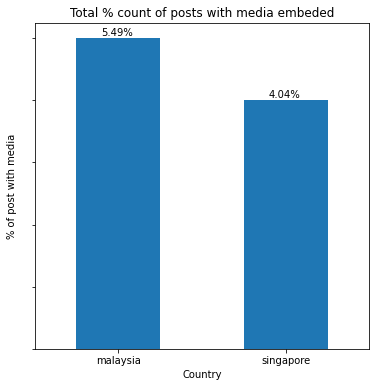

In [14]:
df_me = df[['media_embed','subreddit']].groupby('subreddit').sum()
df_me['media_embed'][0] = df_me['media_embed'][0]/df['subreddit'].value_counts()[0]*100
df_me['media_embed'][1] = df_me['media_embed'][1]/df['subreddit'].value_counts()[1]*100


df_me.plot(kind ='bar',legend=False,figsize=(6,6))
plt.title('Total % count of posts with media embeded')
plt.ylabel('% of post with media')
plt.xlabel('Country')
plt.xticks(rotation=360)
plt.text(0.9,4.05,'4.04%')
plt.text(-0.1,5.05,'5.49%')
plt.yticks(color='w');

While it looks like Malaysian redditors tend to embed slightly more media, the total percentage for both side is not significant and the difference is less then 1%.

#### 2. Which subreddit tend to upload more NSFW posts?

In [15]:
df['over_18'] = df['over_18'].apply(lambda x: 1 if x == True else 0)

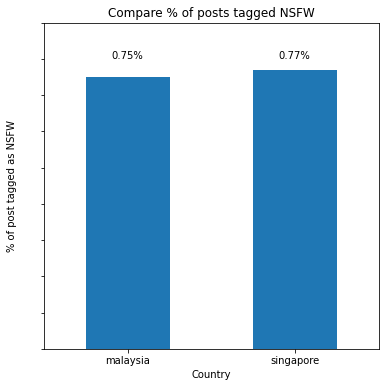

In [16]:
df_nsfw = df[['over_18','subreddit']].groupby('subreddit').sum()
df_nsfw['over_18'] = df_nsfw['over_18'].astype(float)
df_nsfw['over_18'][0] = round(df_nsfw['over_18'][0]/df['subreddit'].value_counts()[0]*100,2)
df_nsfw['over_18'][1] = round(df_nsfw['over_18'][1]/df['subreddit'].value_counts()[1]*100,2)


df_nsfw.plot(kind ='bar',legend=False,figsize=(6,6))
plt.title('Compare % of posts tagged NSFW')
plt.ylabel('% of post tagged as NSFW')
plt.xlabel('Country')
plt.xticks(rotation=360)
plt.yticks(np.arange(0,1,0.1))
plt.text(-0.1,0.8,'0.75%')
plt.text(0.9,0.8,'0.77%')
plt.yticks(color='w')
plt.show()

The amount of post in both subreddits tagged as NSFW is extremely minimal this could be because of the rules set by the moderators to prevent such post from happening.

#### 3. How active are the users with interacting with the different posts?

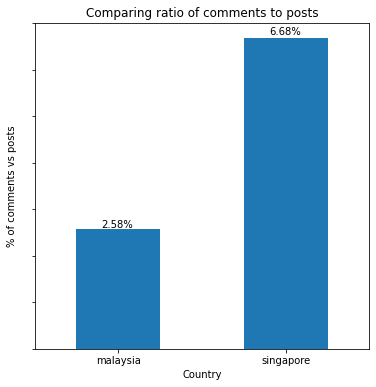

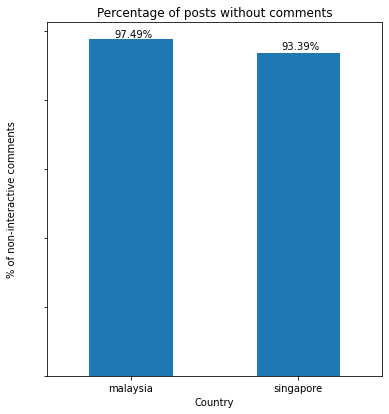

In [17]:
df_cts = df[['num_comments','subreddit']].groupby('subreddit').sum()
df_cts['num_comments'] = df_cts['num_comments'].astype(float)
df_cts['num_comments'][0] = round(df_cts['num_comments'][0]/df['subreddit'].value_counts()[0]*100,2)
df_cts['num_comments'][1] = round(df_cts['num_comments'][1]/df['subreddit'].value_counts()[1]*100,2)

df_cts1 = df[['subreddit','num_comments']][df['num_comments']<1].groupby('subreddit').count()
df_cts1['num_comments'] = df_cts1['num_comments'].astype(float)
df_cts1['num_comments'][0] = round(df_cts1['num_comments'][0]/df['subreddit'].value_counts()[0]*100,2)
df_cts1['num_comments'][1] = round(df_cts1['num_comments'][1]/df['subreddit'].value_counts()[1]*100,2)



df_cts.plot(kind ='bar',legend=False,figsize=(6,6))
plt.title('Comparing ratio of comments to posts')
plt.ylabel('% of comments vs posts')
plt.xlabel('Country')
plt.xticks(rotation=360)
plt.text(-0.1,2.6,'2.58%')
plt.text(0.9,6.75,'6.68%')
plt.yticks(color='w')


df_cts1.plot(kind ='bar',legend=False,figsize=(6,6.5))
plt.title('Percentage of posts without comments')
plt.ylabel('% of non-interactive comments')
plt.xlabel('Country')
plt.xticks(rotation=360)
plt.text(-0.1,98,'97.49%')
plt.text(0.9,94.5,'93.39%')
plt.yticks(color='w')

plt.show()

While the Singaporean subreddit is more active then the malaysian subreddit, with a higher average of comments per post, most posts from both subreddits does not have any comments.

#### 4. Exploring both subreddits using word clouds

In [18]:
#convert column: title to type string and lowercase all
df['title'] = df['title'].astype(str)
df['title'] = df['title'].str.lower()

#Tokenize
df['title'] = df['title'].apply(lambda x: nltk.word_tokenize(x))

#Lemmatize
df = lemma_column(df,'title')

#remove words tagged as verbs
df = remove_verbs(df,'title')

#drop single alphabets
df['title'] = df['title'].apply(lambda x: drop_alphabet(x))

#convert list back to string
df['title'] = df['title'].apply(lambda x: ' '.join(x))

#remove stopwords
df = remove_stopwords(df,'title')

###### Note: 
I chose to lemma the text instead of stemming as stemming would in its zeal to return all words to their base form, cause some words to become unreadable. And for this project that would not do. So while using lemma I might not be able to fully return all words to their base form, it should serve this project best. If I've more time, I would run PorterStemmer and compare the results just for the sake of exploring the different tools available.

                          Word Clouds without taking into account ranking                           


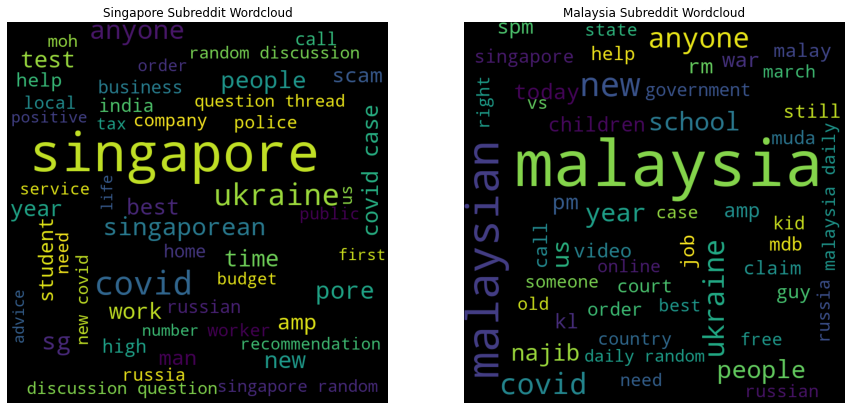

                               Word Clouds base on ranking the top 50                               


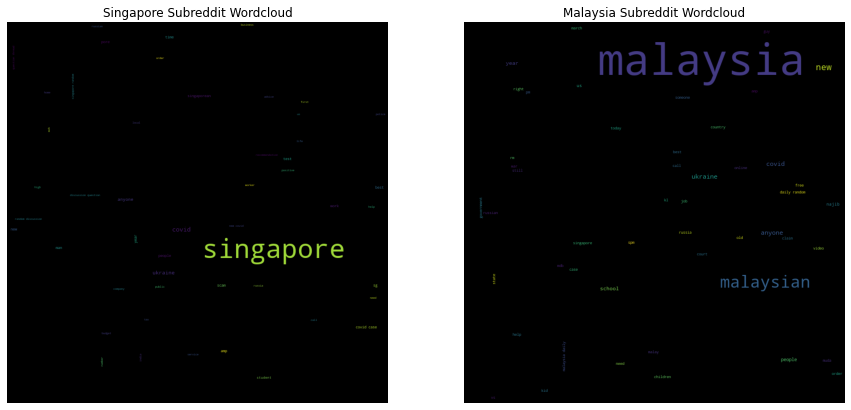

In [19]:
#generate subreddit word clouds

sg = ' '.join(df[df['subreddit']=='singapore']['title'])
msia =' '.join(df[df['subreddit']=='malaysia']['title'])

#word clouds without taking into account ranking base on count of words
print(('Word Clouds without taking into account ranking').center(100))
generate_wc(sg,msia,'Singapore Subreddit Wordcloud','Malaysia Subreddit Wordcloud')

#word clouds based on frequency of top 50 words
print(('Word Clouds base on ranking the top 50').center(100))
generate_wc(sg,msia,'Singapore Subreddit Wordcloud','Malaysia Subreddit Wordcloud',1)

The top two words that stands out (not susprisingly), are the 2 countries name: Singapore and Singaporean, and Malaysia and Malaysian respectively. Interestingly enough, the word Singapore pops out in the lower half of the top 50 for the Malaysian subreddit but that cannot be said of the word Malaysia for the Singapore subreddit.

When we look at the ranking of the words in the top 50 for both subreddit, it is even clearer that the main words found in the titles are Singapore and Malaysia. Perhaps let us try removing the countries' names and see if there are other words that could be unique identifiers of either subreddits.

                          Word Clouds without taking into account ranking                           


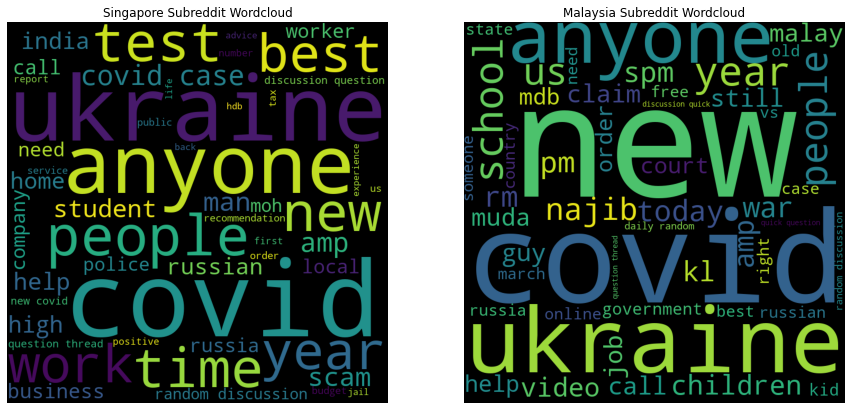

                               Word Clouds base on ranking the top 50                               


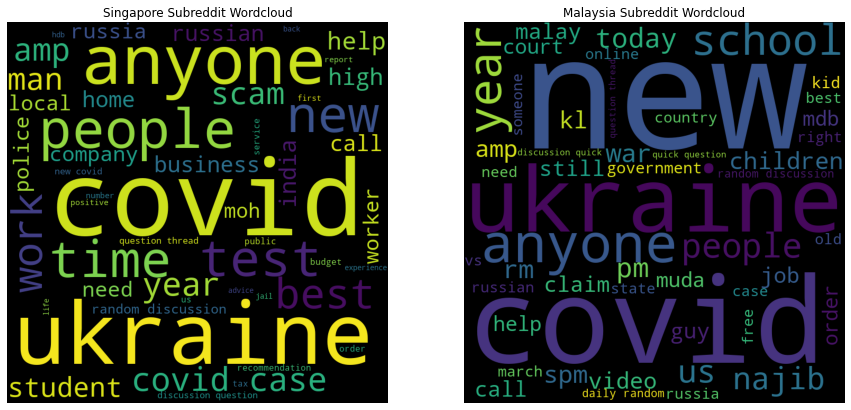

In [20]:
#remove country name
c = ['singapore','singaporean','singaporeans','sg','pore','malaysia','malaysian','malaysians']
df['title'] = df['title'].apply(lambda x:' '.join([i for i in x.split() if i not in c]))

sg = ' '.join(df[df['subreddit']=='singapore']['title'])
msia =' '.join(df[df['subreddit']=='malaysia']['title'])

#generate word clouds without taking into account ranking base on count of words
print(('Word Clouds without taking into account ranking').center(100))
generate_wc(sg,msia,'Singapore Subreddit Wordcloud','Malaysia Subreddit Wordcloud')

#generate word clouds based on frequency of top 50 words
print(('Word Clouds base on ranking the top 50').center(100))
generate_wc(sg,msia,'Singapore Subreddit Wordcloud','Malaysia Subreddit Wordcloud',1)

It looks like the main topics for both countries and perhaps a good representation of the world are the virus: Covid and the Russia-Ukraine conflict. 

Why are the words "anyone" and "new" featured so prominently in both subreddits? 

Are they words that both Singaporeans and Malaysians fall back on in their linguistic habits?

Also does the word 'us' a reflection of the country USA or the pronoun?

We can filter out the titles to take a look:

In [21]:
# Look at first 10 post with the word "new"
for x in df['title'][df['title'].str.contains('new ')][0:10]:
    print(x)

new case dead
slide previous best ever rank th spot january hit th spot february amid wave new case drive omicron variant latest nikkei covid recovery index show
new yamaha lc due could await yamaha lc price rm model update engine upgrade
new case dead
new video
national artistic gymnast farah ann plan sport accord new straits time
new meme template
new case dead
diploma certificate enough new language benefit
mcdonald rm bil years new store


In [22]:
# Look at first 10 post with the word "anyone"

for x in df['title'][df['title'].str.contains('anyone ')][0:10]:
    print(x)

anyone ghost stories share
hello anyone ever jump industry long
banjir kelantan semakin teruk anyone minister
anyone serious jiu jitsu wrestle gym selangor
sure allow share case anyone around kl would support
anyone else havent booster shoot
anyone face serious problem password reset link expire everytime open link mysejahtera
anyone near someone work rubber research institute rrim
call today claim lhdn friends also call different number anyone issue
anyone pay online survey


In [23]:
# Look at first 10 post with the word "us"

for x in df['title'][df['title'].str.contains(' us ')][0:10]:
    print(x)

countryman bring us indonesian sub facepalm
ppb group brace higher grain price wheat grain rocket us bushel first time years corn year high russo ukrainian war
top glove lose rm us ban
former goldman bankers feng shui master mdb probe us trial tell
bfm news twitter order us heirs sulu sultanate reportedly due violation treaty sign sultan sulu sultan jamal al alam baron de overbeck british north borneo company alfred dent
order us heirs sulu sultanate
report ex goldman banker us court get kickbacks third mdb bond jho low claim election
anyone apply us visa embassy kl recently current wait list appointments b visa
hi monyets us internship monyets low cost place home around usj months allowance wont us
mdb trial uae deputy pm najib among recipients us mil briberies allege


"new" seems to be a used frequently as an adjective for news articles.

"anyone" is a reflection of the lingo of both countries.

"us" refers mostly to the USA to be able to properly differentiate between the noun and pronoun of each use case, would be beyond the scope of this project as such I shall leave it as it is.

As we want to find words that would be able to identify the specific subreddit, the word "anyone" could be a good differentiator if we were comparing the broader region to the other regions like say South America versus South East Asia. But in this context I would like to remove as much as possible the common words between the two subreddits. As such I shall do a final removal of the top common words between both base on the above word clouds: ukraine, russia,anyone,help,new, people and a few other common words in both.

                          Word Clouds without taking into account ranking                           


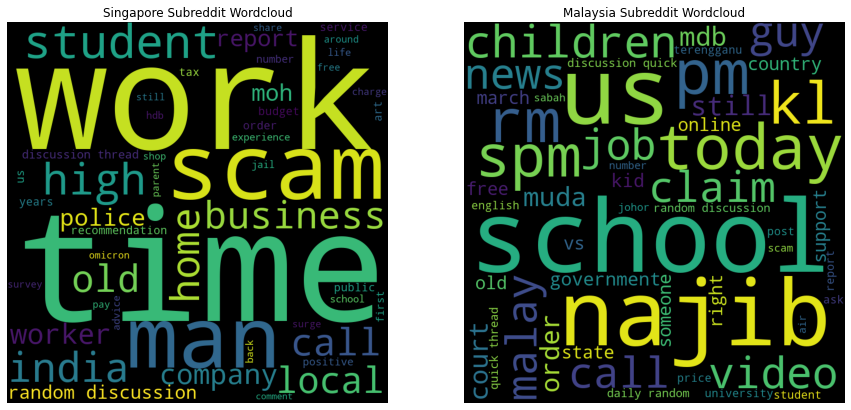

                               Word Clouds base on ranking the top 50                               


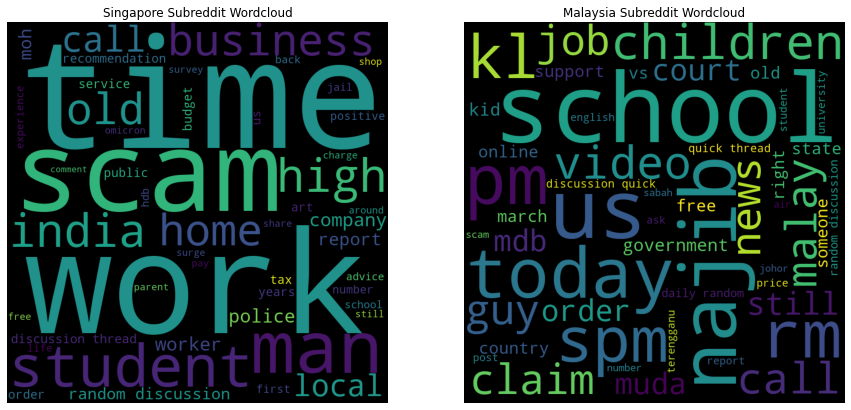

In [24]:
#remove additional common words
c_1 = ['ukraine','covid','anyone','help','new','people','year',
       'russia','russian','war','invasion','case','like','need','test','question','amp','best']
df['title'] = df['title'].apply(lambda x:' '.join([i for i in x.split() if i not in c_1]))

sg = ' '.join(df[df['subreddit']=='singapore']['title'])
msia =' '.join(df[df['subreddit']=='malaysia']['title'])

#generate word clouds without taking into account ranking base on count of words
print(('Word Clouds without taking into account ranking').center(100))
generate_wc(sg,msia,'Singapore Subreddit Wordcloud','Malaysia Subreddit Wordcloud')

#generate word clouds based on frequency of top 50 words
print(('Word Clouds base on ranking the top 50').center(100))
generate_wc(sg,msia,'Singapore Subreddit Wordcloud','Malaysia Subreddit Wordcloud',1)

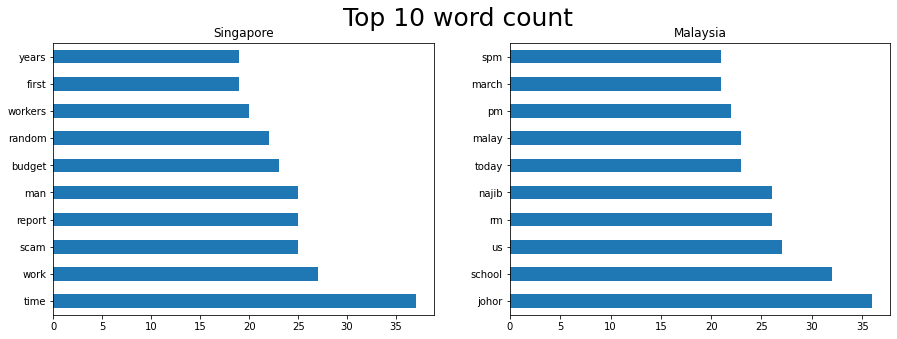

In [25]:
#bar plot using count vectorizer
cvec = CountVectorizer()
cvec.fit(df[df['subreddit']=='singapore']['title'])
cvec_sg = cvec.transform(df[df['subreddit']=='singapore']['title'])
df_cvec_sg = pd.DataFrame(cvec_sg.todense(),columns=cvec.get_feature_names())

cvec1 = CountVectorizer()
cvec1.fit(df[df['subreddit']=='malaysia']['title'])
cvec_msia = cvec1.transform(df[df['subreddit']=='malaysia']['title'])
df_cvec_msia = pd.DataFrame(cvec_msia.todense(),columns=cvec1.get_feature_names())

plt.figure(figsize=(15,5))
plt.suptitle('Top 10 word count',fontsize=25)
plt.subplot(1,2,1)
plt.title('Singapore')
df_cvec_sg.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.subplot(1,2,2)
plt.title('Malaysia')
df_cvec_msia.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.show()

In [26]:
# This was done after modelling and exploring why the models trained did not do well on unseen data. 
# I discovered that after dropping certain words,digits and perhaps alphabets from the titles, 
# the result is a blank string or a string labeled nan.
# I shall remove all rows that are blank strings in this cell.
df = df.drop(df[(df.title == '' )|(df.title == 'nan')].index)

# Preprocessing and Modeling

For the baseline model, I'll be using a a simple logistic regression model with count vectorizer.
I'll then be creating a pipline for tfidf vectorizer and the differnt model, use Gridsearch to find the best parameters, train a random forest classifier and a few other navies bayes models to compare the results and evaluate which model would be a better fit for my data.

Note:
Is standard scaling needed for this project?

As I will be using tfidf that would create some form of scaling for the data, standard scaling before or after would be redundant. As such I shall leave this step out of my machine learning process.

In [27]:
# Declare independent and dependent variables
X = df['title']
y = df['subreddit'].apply(lambda x: 0 if x == 'malaysia' else 1) # Singapore = 1, Malaysia = 0

# Define train test sets, split 80/20
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Baseline Model
Using a simple Logistic Regression model with count vectorizer

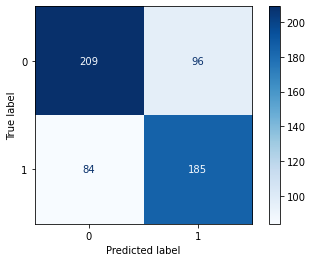

In [28]:
cvec = CountVectorizer()
X_train_cv = cvec.fit_transform(X_train)
X_test_cv = cvec.transform(X_test)

base_lr = LogisticRegression()
base_lr.fit(X_train_cv,y_train)

base_lr_preds = base_lr.predict(X_test_cv)

tn,fp,fn,tp = confusion_matrix(y_test,base_lr_preds).ravel()

plot_confusion_matrix(base_lr,X_test_cv,y_test,cmap='Blues',values_format='d');

#Create a dataframe for the base results to be used later for evaluation
base_name = 'Logistic Regression'
base_lr_dict = {'train_score': base_lr.score(X_train_cv,y_train),
                'test_score': base_lr.score(X_test_cv,y_test),
                'specificity':tn/(tn+fp),
                'recall': tp/(tp+fn),
                'balanced_accuracy':balanced_accuracy_score(y_test,base_lr_preds),
                'best_score':None}

base_lr_df = pd.DataFrame(base_lr_dict.items())
base_lr_df.set_index(0,drop=True,inplace=True)
base_lr_df.rename_axis('Measures',axis='index',inplace=True)
base_lr_df.rename(columns={1:base_name},inplace=True)

### Random Forest Classifier
A model that searches for the best features rather then the most important.

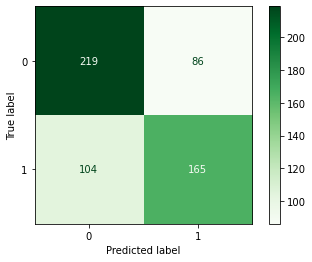

In [29]:
#Create pipeline
rf_pipe = Pipeline([
        ('tvec',TfidfVectorizer()),
        ('rf',RandomForestClassifier())
    ])
#Create parameters
rf_pipe_params= {
        'tvec__max_features':[2000,3000,4000,5000],
        'tvec__ngram_range':[(1,1),(1,2)],
        'rf__n_estimators': [100, 150, 200],
        'rf__max_depth': [None, 1, 2, 3, 4, 5]
    }
#Grid search
rf_gs = GridSearchCV(rf_pipe,
                     param_grid=rf_pipe_params,
                     cv =5)
#fit and predict
rf_gs.fit(X_train,y_train)
rf_gs_preds = rf_gs.predict(X_test)

plot_confusion_matrix(rf_gs,X_test,y_test,cmap='Greens',values_format='d');

### Naive Bayes Classification
Let us try using a range of different implementations of the Naive Bayes algorithm base on Bayes theorem.
Specifically:
* Multinomial
* Complement
* Bernoulli

I would expect the Multinomial Naive Bayes to have the highest accuracy as it is the model best suited for discrete values. But it would be interesting to see how the rest perform in this scenario

In [30]:
#Train the models: Multinomial, Complement, and Bernoulli
nb_multi = pipe_grid_nb_fit(MultinomialNB(),X_train,y_train)
nb_comp = pipe_grid_nb_fit(ComplementNB(),X_train,y_train)
nb_bern = pipe_grid_nb_fit(BernoulliNB(),X_train,y_train)

#Get predictions
nb_multi_preds = nb_multi.predict(X_test)
nb_comp_preds = nb_comp.predict(X_test)
nb_bern_preds = nb_bern.predict(X_test)

# Evaluation

In [31]:
#Model Evaluation

#Base LR
print(f'\033[1mBaseline Model: {base_name}\033[0m\n')
print('Specificity:',base_lr_dict['specificity'])
print('Accuracy:',base_lr_dict['balanced_accuracy'])
print('Score on train set:', base_lr_dict['train_score'])
print('Score on test set:', base_lr_dict['test_score'],'\n')

#Random Forest
rf_gs_df = model_evaluation('Random Forest',rf_gs,rf_gs_preds,X_train,X_test,y_train,y_test)

#Naive Bayes
nb_multi_df = model_evaluation('Multinomial',nb_multi,nb_multi_preds,X_train,X_test,y_train,y_test)
nb_comp_df = model_evaluation('Complement',nb_comp,nb_comp_preds,X_train,X_test,y_train,y_test)
nb_bern_df = model_evaluation('Bernoulli',nb_bern,nb_bern_preds,X_train,X_test,y_train,y_test)

#combine results into a dataframe
dfs = [base_lr_df,rf_gs_df,nb_multi_df,nb_comp_df,nb_bern_df]
df_eval_combine = dfs[0].join(dfs[1:])
df_eval_combine.style.apply(highlight_max,axis=1).apply(highlight_min,axis=1)

Baseline Model: Logistic Regression

Specificity: 0.6852459016393443
Accuracy: 0.6864891218233896
Score on train set: 0.9738219895287958
Score on test set: 0.686411149825784 

Model: Random Forest

Specificity: 0.7180327868852459
Balanced Accuracy: 0.6657078432567494
Score on train set: 0.9978184991273996
Score on test set: 0.6689895470383276
Best estimator: (Pipeline(steps=[('tvec', TfidfVectorizer(max_features=5000)),
                ('rf', RandomForestClassifier(n_estimators=200))]),)
Best parameters: {'rf__max_depth': None, 'rf__n_estimators': 200, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 1)} 

Model: Multinomial

Specificity: 0.6819672131147541
Balanced Accuracy: 0.7145895545127674
Score on train set: 0.9520069808027923
Score on test set: 0.7125435540069687
Best estimator: (Pipeline(steps=[('tvec', TfidfVectorizer(max_features=5000)),
                ('nb', MultinomialNB())]),)
Best parameters: {'tvec__max_features': 5000, 'tvec__ngram_range': (1, 1)} 

Model: Compleme

,Logistic Regression,Random Forest,Multinomial,Complement,Bernoulli
Measures,,,,,
train_score,0.973822,0.997818,0.952007,0.928447,0.931937
test_score,0.686411,0.668990,0.712544,0.707317,0.688153
specificity,0.685246,0.718033,0.681967,0.727869,0.596721
recall,0.687732,0.613383,0.747212,0.684015,0.791822
balanced_accuracy,0.686489,0.665708,0.714590,0.705942,0.694271
best_score,nan,0.661421,0.677983,0.682783,0.681051


The results of my models are a little disappointing. All show extreme overfitting. The random forest classifier fared the worst. Surprisingly, the baseline logistic regression model help up pretty well.

Since the Multinomial model has the highest test score and best accuracy, let's take a look at some of the post that were mislabeled.

In [32]:
#create dataframe of predicted vs actual results
c = [X_test,y_test,nb_multi_preds]
c1 = pd.DataFrame(c).T
c1.reset_index(drop=True,inplace=True)
c1.rename(columns={'subreddit':'actual','Unnamed 0':'predicted'},inplace=True)
c1['predicted'].fillna(0,inplace=True)
c1['predicted'] = c1['predicted'].astype(int)
c1['actual'] = c1['actual'].astype(int)
#convert the catergorical variables back to strings
c1[['actual','predicted']] = c1[['actual','predicted']].applymap(lambda x: 'singapore' if x==1 else 'malaysia')
#shuffle the rows
c1 = c1.sample(frac=1).reset_index(drop=True)
#show only mislabeled
c1[c1['actual']!=c1['predicted']].head(20)

,title,actual,predicted
0,online museum scientist malaya trip,malaysia,singapore
7,double life wive duke nus researcher spy us,singapore,malaysia
9,kl bangkok hsr idea better economic sense expert,malaysia,singapore
10,kdrama vs drama,malaysia,singapore
14,house waterfall basement walk wine cellar,singapore,malaysia
16,putin pm lee pres yacob,singapore,malaysia
18,upcoming sale scoot,singapore,malaysia
19,infantcare teacher admit hit old boy slam face,singapore,malaysia
21,true,malaysia,singapore
23,language origin mrt station name,singapore,malaysia


Just from looking at the list, nothing truly stands out. It could be that certain words in the test data was not accounted for in the train data.

While the random forest classifier did manage to give a solid prediction on unseen data, let us take a look at its top 20 features.

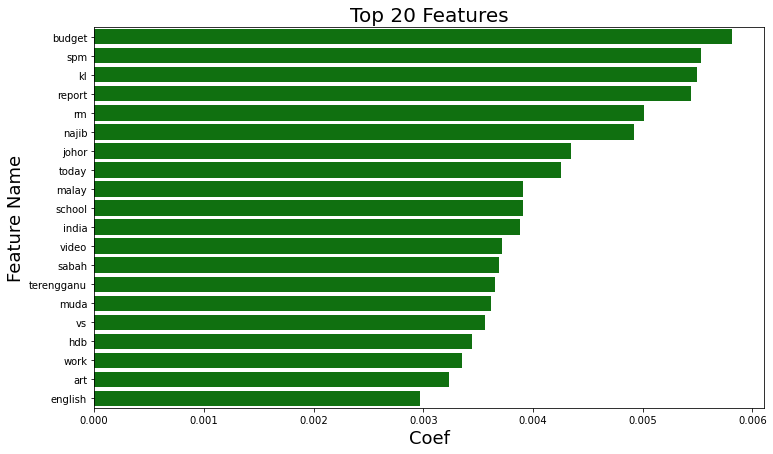

In [33]:
rf_importance = rf_gs.best_estimator_.named_steps['rf'].feature_importances_
rf_feature_names = rf_gs.best_estimator_.named_steps['tvec'].get_feature_names()

# Zip coefficients and names together and make a DataFrame
zipped = zip(rf_feature_names, rf_importance)
rf_df = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
rf_df["abs_value"] = rf_df["value"].apply(lambda x: abs(x))
rf_df["colors"] = rf_df["value"].apply(lambda x: "green" if x > 0 else "red")
rf_df = rf_df.sort_values("abs_value", ascending=False)
# Generate plot
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="value",
            y="feature",
            data=rf_df.head(20),
           palette=rf_df.head(20)["colors"])
ax.set_title("Top 20 Features", fontsize=20)
ax.set_xlabel("Coef", fontsize=18)
ax.set_ylabel("Feature Name", fontsize=18);

We can also look at the top 10 features from the Multinominal model for both of the subreddits and see how they compare to the random forest classifer.

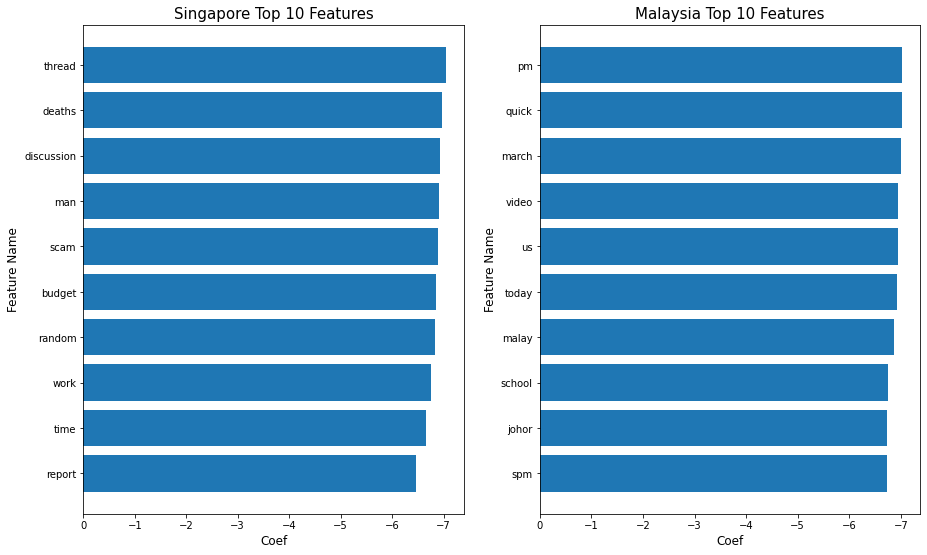

In [34]:
sg_features = nb_multi.best_estimator_.named_steps['nb'].feature_log_prob_[1]
msia_features = nb_multi.best_estimator_.named_steps['nb'].feature_log_prob_[0]
feature_names = nb_multi.best_estimator_.named_steps['tvec'].get_feature_names()

sg_zipped = zip(feature_names, sg_features)
msia_zipped = zip(feature_names, msia_features)

sg_top_features = pd.DataFrame(sg_zipped,columns=["feature", "value"]).sort_values(by = 'value',ascending=False).head(10)
msia_top_features = pd.DataFrame(msia_zipped,columns=["feature", "value"]).sort_values(by = 'value',ascending=False).head(10)

fig, ax = plt.subplots(1,2, figsize=(15,9));
    
# plot the first graph
plt.subplot(1,2,1)

plt.barh(sg_top_features['feature'],sg_top_features['value'])
plt.title("Singapore Top 10 Features", fontsize=15)
plt.xlabel("Coef", fontsize=12)
plt.ylabel("Feature Name", fontsize=12)
plt.gca().invert_xaxis()  

# plot the second graph
plt.subplot(1,2,2)
plt.barh(msia_top_features['feature'],msia_top_features['value'])
plt.title("Malaysia Top 10 Features", fontsize=15)
plt.xlabel("Coef", fontsize=12)
plt.ylabel("Feature Name", fontsize=12)
plt.gca().invert_xaxis()

plt.show()

From the features itself we actually are able to roughly see the main concern of the netizens from the different subreddits.

# Conclusion and Recommendations

### Conclusion
When I started this project I knew at the back of my mind that I might not be able to properly train a model to predict if a post comes from Singapore or a Malaysia due to their close proxmity to each other.

Never the less given the task, I first started the project by webscrapping 1,500 post from the subreddits: Malaysia and Singapore. From there I did some basic cleaning, removing digits and special characters from the titles. Upon realising that 80% of the post did not have any content, I decided to drop the text in the content.

Some interesting ideas were explored during the EDA.
1. Which netizens was more likely to embed media: Malaysia
2. What was the percentage of post tagged NSFW: less then 1% for both
3. Which subreddit was more active in terms of average comments: Singapore

I then generated word clouds to futher analyse the top subject or words from both community. Once I removed the current global topics of the war in Europe and the current virus pandemic, it could be clearly seen that the major concern of Singaporeans were: scam, time, and studies. While for the Malaysian, they were more concern with their education system and political figures/groups.

Finally using NLP I trained a few models that would be able to automatically detect if a post is coming from Singapore or Malaysia, but was not able to get a strong result. I strongly suspect that this is due to the data gather and cleaning stages and more could be done in that area. For now the model and analysis could perhaps give the team a rough indication on the users inclinations and location. But more work needs to be done.

### Recomendations and Future Steps
1. 1,500 post per subreddit is not enough. The top word count for each subreddit is less then 40. This could be a big reason why the random forest classifier fared so badly.
2. The datasets included post that were removed. This could explain why most post lack content. Perhaps a better way would be to filter and work with only posts that were still 'live'.
3. Following point 2, it would be more holistic if I could include or run the EDA and Modeling on the content itself rather then just the title.
4. As the Malaysia subreddit consisted of post in a mix of both English and Malay, I should have used an API like Google Translation API, to convert the text to english if possible. This would give better accuracy when using stopwords and lemma.
5. Mentioned earlier the content of the words used is very important in this project. There could be better results if a linguist who specialise in both countries spoken and written habits were to work together on this project.
6. The subreddits are not the full reflection of the countries' reddit population. As there are other splinter subreddits. For example, for singapore there is the [SingaporeRaw](https://www.reddit.com/r/SingaporeRaw/),[singaporefi](https://www.reddit.com/r/singaporefi/), [askSingapore](https://www.reddit.com/r/askSingapore/), etc. To wider and more diverse set of data, these subreddits could be included for better analysis and model building.

### Limitations/ Disclaimer
- Malaysia's population as of 2020 is 32.37 million [source](https://datacommons.org/place/country/MYS?utm_medium=explore&mprop=count&popt=Person&hl=en) and Singapore's population in 2020 stood at 5.69 million [source](https://datacommons.org/place?utm_medium=explore&dcid=country/SGP&mprop=count&popt=Person&hl=en). The above analysis is only of 1,500 post made by different subredditors. Even if we were to assume each post is of a different person, that would make up less then 0.005% of the population in each country.

- Even though the subreddits are named Malaysia and Singapore, they're run on a global platform that is open for anyone to post or comment. As such some of these post could be from either countries or even citizens from other nations.

## Appendix

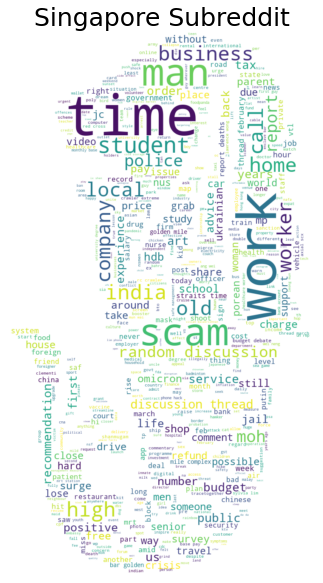

In [35]:
# For presentation purposes word cloud with merlion as mask

mask = np.array(Image.open('./assets/images/singapore_merlion.png'))

wcd = wc.WordCloud(mask = mask,
                   background_color='white',
                   max_words=550,
                   max_font_size=256,
                   width=mask.shape[1],
                   height=mask.shape[0])

wcd.generate(sg)


plt.figure(figsize=(15,10))
plt.title('Singapore Subreddit',fontsize=25)
plt.imshow(wcd,interpolation='bilinear')
plt.axis('off')
plt.show()
wcd.to_file('./assets/images/wc_merlion.png')

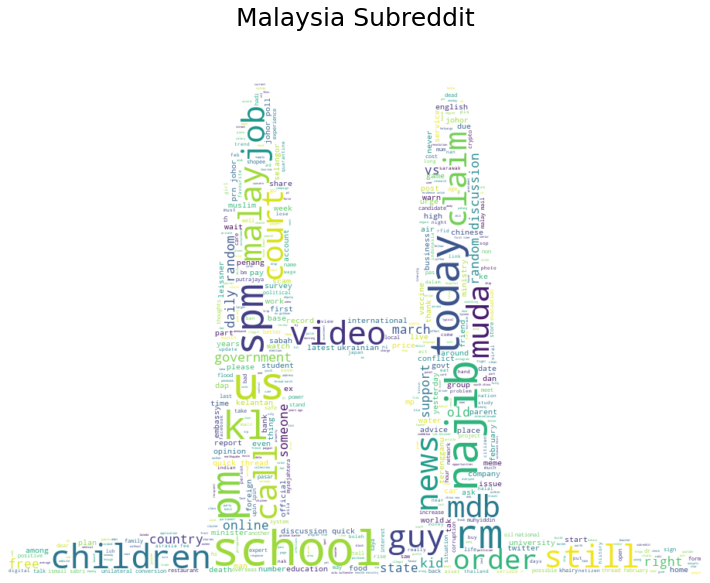

In [36]:
# For presentation purposes word cloud with twin tower as mask

mask = np.array(Image.open('./assets/images/msia_twin_tower.png'))

wcd = wc.WordCloud(mask = mask,
                   background_color='white',
                   max_words=550,
                   max_font_size=256,
                   width=mask.shape[1],
                   height=mask.shape[0])

wcd.generate(msia)


plt.figure(figsize=(15,10))
plt.title('Malaysia Subreddit',fontsize=25)
plt.imshow(wcd,interpolation='bilinear')
plt.axis('off')
plt.show()
wcd.to_file('./assets/images/wc_twintower.png')